In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import math

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data_folder = "dontpatronizeme_v1.4/"

## Load data

In [4]:
pcl_df = pd.read_csv(f"{data_folder}/dontpatronizeme_pcl.tsv", sep='\t', on_bad_lines='skip')
cat_df = pd.read_csv(f"{data_folder}/dontpatronizeme_categories.tsv", sep='\t', on_bad_lines='skip')

In [7]:
pcl_df.columns

Index(['------------------------------------------------------ DISCLAIMER ------------------------------------------------------'], dtype='object')

In [8]:
def load_and_preprocess_data(path, col_names):

    original_data=[]

    with open (path) as data:
        for line in data:
            original_data.append(line)
            
    print('The original data contains ', len(original_data), ' lines.')
    
    lines = []

    for line in original_data:
        elements=line.strip().split('\t')
        lines.append(elements)
    
    df = pd.DataFrame(lines, columns = col_names)

    # remove the 0-3 rows since they don't contain any data
    df = df.iloc[4:].reset_index(drop=True)

    return df

In [9]:
pcl_cols = ["par_id", "art_id", "keyword", "country_code", "text", "label"]
cat_cols = ["par_id", "art_id", "text", "keyword", "country_code", "span_start", "span_finish", "span_text", "pcl_category", "number_of_annotators"]

In [10]:
pcl_df = load_and_preprocess_data(f"{data_folder}/dontpatronizeme_pcl.tsv", pcl_cols)
cat_df = load_and_preprocess_data(f"{data_folder}/dontpatronizeme_categories.tsv", cat_cols)

The original data contains  10473  lines.
The original data contains  2764  lines.


In [55]:
## change label dtype to int
pcl_df['label'] = pcl_df['label'].astype(int)

In [56]:
## repllace labels 1, 2, 3, 4 with 1

pcl_df['label'] = pcl_df['label'].replace([1, 2, 3, 4], 1)

In [57]:
pcl_df

,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0
...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1


<AxesSubplot: >

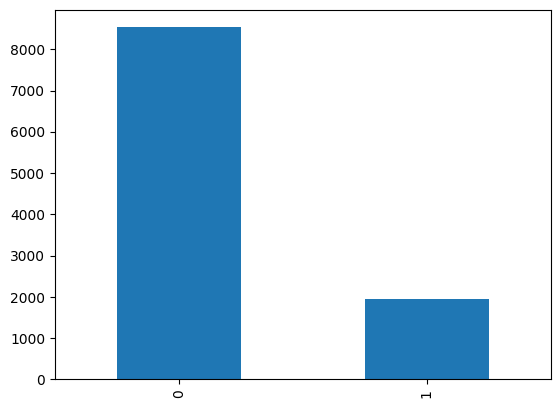

In [58]:
## plot the distribution of the labels

pcl_df['label'].value_counts().plot(kind='bar')
plt.show()

## Part 1

### Part 1.1 Analysis of the class labels: how frequent these are and how they correlate with any feature of the data, e.g. input length.

In [59]:
pcl_df["label"] = pcl_df["label"].astype(int)

In [60]:
# create class (1 for PCL 0 for non-PCL) based on label 
pcl_df["class"] = pcl_df.apply(lambda x: 1 if x["label"] > 1 else 0, axis=1)

#### How frequent class labels are

In [61]:
pcl_df.value_counts("class")

class
0    10469
dtype: int64

#### Create data features

In [62]:
pcl_df["text_len"] = pcl_df["text"].apply(lambda x: len(x))

In [63]:
pcl_df["text_len"].describe()

count    10469.000000
mean       267.582864
std        160.209494
min          0.000000
25%        169.000000
50%        233.000000
75%        330.000000
max       5501.000000
Name: text_len, dtype: float64

In [64]:
# discretize text length
text_len_bin_edges = list(range(0, (math.ceil(pcl_df["text_len"].max()/100) + 1)*100, 100))
pcl_df['text_len_binned'] = pd.cut(pcl_df['text_len'], bins=text_len_bin_edges).astype(str)

#### Check correlation between class and data features

In [65]:
!pip install nltk


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [66]:
## Preprocessing of the data

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove new lines
    text = re.sub(r'   ', ' ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # stem
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

pcl_df['text'] = pcl_df['text'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deveshjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deveshjoshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deveshjoshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
pcl_df

,par_id,art_id,keyword,country_code,text,label,class,text_len,text_len_binned
0,1,@@24942188,hopeless,ph,we live time absolut insan i pretti sure peopl...,0,0,620,"(600, 700]"
1,2,@@21968160,migrant,gh,in libya today countless number ghanaian niger...,0,0,237,"(200, 300]"
2,3,@@16584954,immigrant,ie,white hous press secretari sean spicer said fo...,0,0,162,"(100, 200]"
3,4,@@7811231,disabled,nz,council custom sign would display two space wo...,0,0,162,"(100, 200]"
4,5,@@1494111,refugee,ca,just like receiv migrant flee el salvador guat...,0,0,277,"(200, 300]"
...,...,...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,sri lankan norm cultur inhibit woman take part...,1,0,348,"(300, 400]"
10465,10466,@@70091353,vulnerable,ph,he ad afp continu bank applic whole nation who...,0,0,258,"(200, 300]"
10466,10467,@@20282330,in-need,ng,she one huge platform inform go place realli n...,1,0,286,"(200, 300]"
10467,10468,@@16753236,hopeless,in,anja ringgren loven i ca nt find word describ ...,1,0,502,"(500, 600]"


## Synonym Replacement

In [68]:
## Data Augnmentation synonym replacement

import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

def synonym_replacement(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    return augmented_text[0]

## augment the data with label 1

pcl_df_aug = pcl_df[pcl_df["label"] == 1].copy()
pcl_df_aug["text"] = pcl_df_aug["text"].apply(lambda x: synonym_replacement(x))
pcl_df_aug["label"] = 1
pcl_df_aug["class"] = 1

pcl_df_aug

## concat the original data with the augmented data

pcl_df = pd.concat([pcl_df, pcl_df_aug], ignore_index=True)



,par_id,art_id,keyword,country_code,text,label,class,text_len,text_len_binned
8,9,@@3449225,homeless,ph,nueva era iloco nort no famili shall homeless ...,1,1,138,"(100, 200]"
32,33,@@8301323,disabled,pk,arshad say besid learn mani new aspect sport l...,1,1,244,"(200, 300]"
33,34,@@24150149,disabled,ng,tight food for thought employe fed disabl man ...,1,1,66,"(0, 100]"
35,36,@@20493025,homeless,ng,the foundat urg will rais investment trust hom...,1,1,123,"(100, 200]"
37,38,@@19143133,hopeless,bd,rizvi there joyousness eid h the citizen carry...,1,1,95,"(0, 100]"
...,...,...,...,...,...,...,...,...,...
10453,10454,@@22338535,vulnerable,ie,we challeng i suggest turn prison term celebr ...,1,1,244,"(200, 300]"
10464,10465,@@14297363,women,lk,sri lankan norm cultur inhibit womanhood take ...,1,1,348,"(300, 400]"
10466,10467,@@20282330,in-need,ng,she one immense platform inform pass place rea...,1,1,286,"(200, 300]"
10467,10468,@@16753236,hopeless,in,anja ringgren loven i ca nt ascertain word des...,1,1,502,"(500, 600]"


<AxesSubplot: >

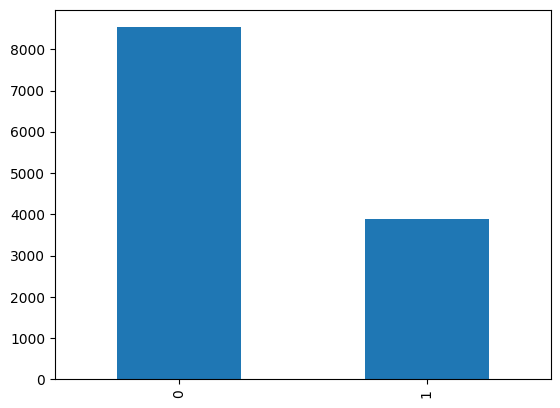

In [69]:
## plot the distribution of the labels

pcl_df['label'].value_counts().plot(kind='bar')
plt.show()

In [70]:
pcl_df_aug['text'].iloc[0][0]

'n'

## Random Swap

In [71]:
## Random swap  of words

import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

def random_swap(text):
    aug = naw.RandomWordAug(action="swap")
    augmented_text = aug.augment(text)
    return augmented_text[0]

## augment the data with label 1

pcl_df_aug = pcl_df[pcl_df["label"] == 1].copy()
pcl_df_aug["text"] = pcl_df_aug["text"].apply(lambda x: random_swap(x))

pcl_df_aug

## concat the original data with the augmented data

pcl_df = pd.concat([pcl_df, pcl_df_aug], ignore_index=True)


,par_id,art_id,keyword,country_code,text,label,class,text_len,text_len_binned
8,9,@@3449225,homeless,ph,era iloco nueva no nort shall famili homeless ...,1,0,138,"(100, 200]"
32,33,@@8301323,disabled,pk,said arshad besid learn mani new aspect sport ...,1,0,244,"(200, 300]"
33,34,@@24150149,disabled,ng,fast employe food fed disabl man becom interne...,1,0,66,"(0, 100]"
35,36,@@20493025,homeless,ng,the foundat urg will fund rais victim homeless...,1,0,123,"(100, 200]"
37,38,@@19143133,hopeless,bd,rizvi there joy eid the h nation citizen hopel...,1,0,95,"(0, 100]"
...,...,...,...,...,...,...,...,...,...
12404,10454,@@22338535,vulnerable,ie,I we challeng suggest turn celebr prison term ...,1,1,244,"(200, 300]"
12405,10465,@@14297363,women,lk,Norm sri lankan cultur inhibit womanhood take ...,1,1,348,"(300, 400]"
12406,10467,@@20282330,in-need,ng,one she platform immense inform place pass rea...,1,1,286,"(200, 300]"
12407,10468,@@16753236,hopeless,in,anja ringgren i loven ca nt word ascertain des...,1,1,502,"(500, 600]"


<AxesSubplot: >

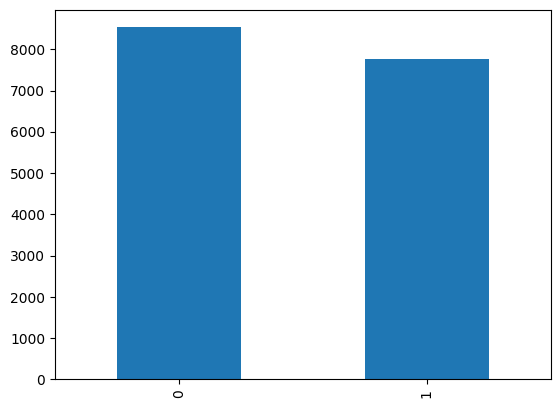

In [72]:
## plot the distribution of the labels

pcl_df['label'].value_counts().plot(kind='bar')
plt.show()

In [73]:
pcl_df

,par_id,art_id,keyword,country_code,text,label,class,text_len,text_len_binned
0,1,@@24942188,hopeless,ph,we live time absolut insan i pretti sure peopl...,0,0,620,"(600, 700]"
1,2,@@21968160,migrant,gh,in libya today countless number ghanaian niger...,0,0,237,"(200, 300]"
2,3,@@16584954,immigrant,ie,white hous press secretari sean spicer said fo...,0,0,162,"(100, 200]"
3,4,@@7811231,disabled,nz,council custom sign would display two space wo...,0,0,162,"(100, 200]"
4,5,@@1494111,refugee,ca,just like receiv migrant flee el salvador guat...,0,0,277,"(200, 300]"
...,...,...,...,...,...,...,...,...,...
16284,10454,@@22338535,vulnerable,ie,I we challeng suggest turn celebr prison term ...,1,1,244,"(200, 300]"
16285,10465,@@14297363,women,lk,Norm sri lankan cultur inhibit womanhood take ...,1,1,348,"(300, 400]"
16286,10467,@@20282330,in-need,ng,one she platform immense inform place pass rea...,1,1,286,"(200, 300]"
16287,10468,@@16753236,hopeless,in,anja ringgren i loven ca nt word ascertain des...,1,1,502,"(500, 600]"
